##**Analiza Wiekowa za Pomocą Sieci Konwolucyjnych CNN**

**Cel Instrukcji:**

Celem niniejszej instrukcji jest zapoznanie z podstawami budowy i analizy konwolucyjnych sieci neuronowych (CNN) w zadaniach regresji, na przykładzie estymacji wieku opartych na analizie zdjęć twarzy.

Sieci konwolucyjne (CNN) to klasa głębokich sieci neuronowych, które są szczególnie skuteczne w przetwarzaniu danych mających strukturę siatki, takich jak obrazy. CNN wykorzystują warstwy konwolucyjne, które automatycznie i adaptacyjnie uczą się przestrzennych hierarchii cech z obrazów. W kontekście regresji, takiej jak estymacja wieku, CNN uczą się mapować surowe obrazy na wartości ciągłe (wiek), stosując serię filtrów konwolucyjnych do ekstrakcji cech oraz gęstych warstw do predykcji wartości numerycznych.

##**Etap 1: Wczytywanie i Analiza Danych**

Analiza danych jest kluczowym elementem każdego projektu z zakresu uczenia maszynowego. Pozwala zrozumieć charakterystykę zbioru danych, w tym rozkład, brakujące wartości i potencjalne anomalie. W przypadku analizy wiekowej, istotne jest zrozumienie rozkładu wieku w zbiorze danych, ponieważ nierównomierny rozkład może wpływać na wyniki uczenia modelu.

In [17]:
import os
import numpy as np
import tensorflow as tf
import random as python_random
# from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Aby zapewnić powtarzalność wyników, ważne jest kontrolowanie losowości w procesach inicjalizacji modelu, selekcji danych oraz podczas treningu. Jednocześnie, biorąc pod uwagę ograniczenia czasowe, model musi być wystarczająco prosty, aby umożliwić szybkie trenowanie, ale jednocześnie złożony na tyle, aby efektywnie rozwiązać zadanie regresji wieku.

In [18]:
# Ustawienie ziarna losowości dla powtarzalności wyników
def set_seeds(seed=123):
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

set_seeds()

In [19]:
# Podłączenie Dysku Google
# Ścieżka do pliku zip 'statystyka.zip'
statystyka_zip_path = 'statystyka.zip'

# Rozpakowanie pliku 'statystyka.zip'
with zipfile.ZipFile(statystyka_zip_path, 'r') as zip_ref:
    zip_ref.extractall('dane/')

# Ścieżka do folderu z danymi po rozpakowaniu
folder_path = './dane/statystyka/'

# Wczytanie pliku labels.csv
labels = pd.read_csv(folder_path + 'labels.csv')

C:\Users\j.mazur\AppData\Local\Temp\ipykernel_34096\2312605420.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(labels['real_age'], rug=True, kde_kws={'shade':True, 'color':'r'})
c:\Users\j.mazur\Documents\statystyka\.venv\Lib\site-packages\seaborn\distributions.py:2496: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


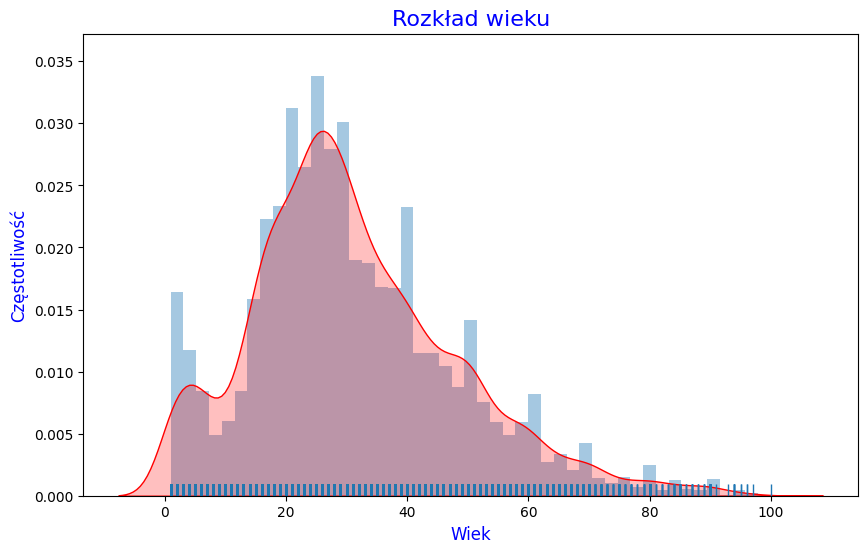

In [20]:
# Wizualizacja rozkładu wieku
plt.figure(figsize=(10, 6))
sns.distplot(labels['real_age'], rug=True, kde_kws={'shade':True, 'color':'r'})
plt.xlabel('Wiek', fontsize=12, color='b')
plt.ylabel('Częstotliwość', fontsize=12, color='b')
plt.title('Rozkład wieku', fontsize=16, color='b')
plt.show()

In [21]:
# Rozpakowanie pliku ZIP z obrazami
zip_path = folder_path + 'final_files.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

# Definicja ścieżki do rozpakowanego folderu
extracted_folder = folder_path + 'final_files/'

# Sprawdzenie zawartości folderu
print("Lista plików w folderze:", os.listdir(extracted_folder)[:10]) # Wyświetla pierwsze 10 plików

Lista plików w folderze: ['000000.jpg', '000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg']


Zadanie dla studentów:

Przeprowadź krótką analizę danych zawartych w pliku labels.csv. Jakie wnioski można wysnuć z przedstawionego rozkładu wieku? Jak mogą one wpłynąć na proces trenowania modelu i jego wyniki?

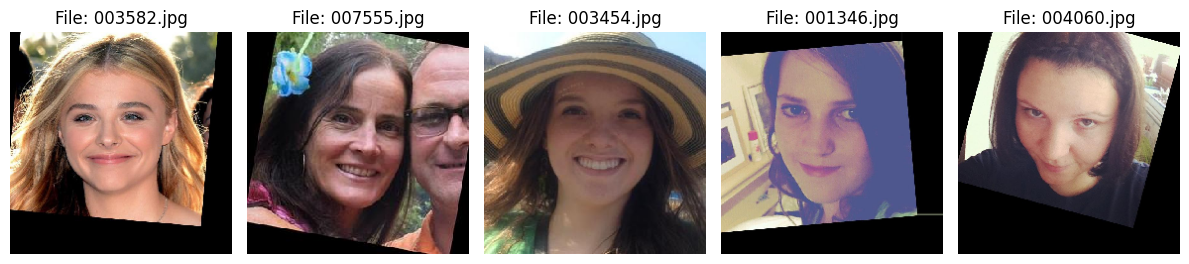

In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Wizualizacja kilku obrazów z bazy danych
def visualize_sample_images(directory, num_images=5):
    sample_files = np.random.choice(os.listdir(directory), num_images)
    plt.figure(figsize=(12, 6))
    for i, file in enumerate(sample_files):
        img_path = os.path.join(directory, file)
        img = load_img(img_path, target_size=(224, 224))
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'File: {file}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_sample_images(extracted_folder)

Zadanie dla Studentów:

Przeanalizuj poniższy kod służący do wizualizacji obrazów. Jakie informacje można uzyskać z tych wizualizacji? Czy widzisz jakieś wyzwania związane z jakością lub różnorodnością obrazów?

##**Etap 2: Budowa i Trenowanie Modelu Sieci CNN**

Konwolucyjne sieci neuronowe (CNN) są szczególnie efektywne w analizie obrazów dzięki swojej zdolności do wykrywania cech na różnych poziomach abstrakcji. W kontekście regresji, jak estymacja wieku, sieci CNN uczą się przewidywać ciągłe wartości numeryczne (wiek) na podstawie cech wyekstrahowanych z obrazów.

In [23]:
# Tworzenie obiektu ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.25  # 25% danych na zestaw walidacyjny
)

# Tworzenie generatora dla zestawu treningowego
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=extracted_folder,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='training',
    seed=123
)

# Tworzenie generatora dla zestawu walidacyjnego
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=extracted_folder,
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=123
)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


Zadanie dla Studentów:

Przeanalizuj poniższy kod dotyczący przygotowania danych za pomocą ImageDataGenerator. Jakie są korzyści z używania takiego generatora? Jakie znaczenie ma parametr validation_split?

Zastanów się, dlaczego wybór odpowiedniego batch_size i target_size jest ważny w kontekście efektywności trenowania modelu i jakości wyników.

In [24]:
# Budowa modelu sieci CNN

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

def create_model(input_shape):
    set_seeds()  # Ustawienie ziarna losowości

    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0003), loss='mae', metrics=['mae'])

    return model

model = create_model(input_shape=(224, 224, 3))
model.summary()

94765736/94765736 [==============================] - 64s 1us/step


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 23536641 (89.79 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


Zadanie dla Studentów:

Przeanalizuj poniższy kod dotyczący budowy modelu. Jakie elementy architektury sieci są kluczowe dla zadania regresji? W jaki sposób warstwy sieci współpracują, aby przewidywać wiek na podstawie obrazu?

Zastanów się, w jaki sposób można by ulepszyć lub dostosować ten model do lepszego przewidywania wieku. Jakie zmiany mogłyby przyspieszyć proces trenowania bez znacznego wpływu na dokładność?

In [25]:
# Trenowanie modelu sieci CNN

def train_model(model, train_data, validation_data, batch_size=32, epochs=12, steps_per_epoch=100, validation_steps=50):
    set_seeds()  # Ustawienie ziarna losowości

    model.fit(
        train_data,
        validation_data=validation_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=1
    )
    return model

model = train_model(model, train_generator, validation_generator)

Epoch 1/12
100/100 [==============================] - 3870s 39s/step - loss: 12.9583 - mae: 12.9583 - val_loss: 14.6644 - val_mae: 14.6644
Epoch 2/12
  6/100 [>.............................] - ETA: 1:47:11 - loss: 10.8013 - mae: 10.8013

##**Etap 3: Analiza Wyników i oraz sprawdzenie skuteczności modelu**

Analiza wyników treningu i walidacji modelu sieci CNN jest kluczowa do zrozumienia jego skuteczności i obszarów, które wymagają poprawy. W kontekście regresji wieku, ważne jest zwrócenie uwagi nie tylko na wartości błędów (loss i mae), ale także na to, jak model zachowuje się na różnych danych, w tym na nowych, niewidzianych obrazach.

In [ ]:
# Ewaluacja modelu na zestawie walidacyjnym
validation_loss, validation_mae = model.evaluate(validation_generator, verbose=1)
print(f'Validation Loss: {validation_loss}')
print(f'Validation MAE: {validation_mae}')

In [ ]:
# Wizualizacja wyników
def visualize_predictions(model, generator, num_samples=10):
    features, targets = next(generator)
    predictions = model.predict(features)

    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(features[i])
        plt.title(f'Przewidziany/Rzeczywisty: {int(predictions[i][0])}/{targets[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, validation_generator)

Zadanie dla Studentów:

Przeanalizuj wyniki treningu i walidacji modelu (wartości validation_loss i validation_mae). Jak interpretować te wyniki? Jakie wnioski można wyciągnąć odnośnie skuteczności modelu?

**Dodawanie i Analiza Własnych Zdjęć**

Zadanie dla Studentów:

Dodaj własne zdjęcie do modelu i zobacz, jaki wiek przewiduje. Czy wyniki są zgodne z oczekiwaniami? Jakie czynniki mogą wpływać na dokładność przewidywań modelu na nowych danych?

In [ ]:
from google.colab import files
from io import BytesIO
from PIL import Image

def upload_and_predict_multiple(model):
    print("Proszę przesłać zdjęcia...")
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Ładowanie, konwersja do RGB i wyświetlanie obrazu
        img = Image.open(BytesIO(uploaded[filename]))
        img_rgb = img.convert('RGB')  # Konwersja do RGB
        img_resized = img_rgb.resize((224, 224))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

        # Przetwarzanie obrazu i przewidywanie wieku
        img_array = np.array(img_resized) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        predicted_age = model.predict(img_array)
        print(f'Przewidywany wiek dla {filename}: {predicted_age[0][0]}')

# Wywołanie funkcji do przesyłania, wyświetlania i przewidywania wieku dla wielu zdjęć
upload_and_predict_multiple(model)

**Wnioski z przeprowadzonej analizy:**

Na podstawie całego procesu, od analizy danych po przewidywania na nowych obrazach, jakie wnioski możesz wyciągnąć o skuteczności i ograniczeniach modelu? Jakie zmiany można by wprowadzić, aby poprawić jego wydajność?
